### Student Information
Name: Keith Saudjana

Student ID: 113062421

GitHub ID: Keith-Saudjana

Kaggle name:

Kaggle private scoreboard snapshot:

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

### 0. Initialization

In [ ]:
# import library
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import umap
import gensim
import tensorflow
import keras
import ollama
import langchain
import langchain_community
import langchain_core
import bs4
import chromadb
import gradio
import json

%matplotlib inline

print("gensim: " + gensim.__version__)
print("tensorflow: " + tensorflow.__version__)
print("keras: " + keras.__version__)

gensim: 4.3.3
tensorflow: 2.18.0
keras: 3.6.0


### 1. Data Preparation

#### 1.1 Load Data

In [4]:
tweets = pd.read_json(r'data/tweets_DM.json', lines=True)

In [5]:
print('extract _source')
tweets = tweets['_source'].apply(pd.Series) 
    
print('extract _values')
tweets = tweets['tweet'].apply(pd.Series)[['tweet_id', 'text']]

extract _source
extract _values


In [7]:
tweets

,tweet_id,text
0,0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,0x28b412,"Confident of your obedience, I write to you, k..."
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,0x2de201,"""Trust is not the same as faith. A friend is s..."
...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...
1867531,0x29d0cb,I swear all this hard work gone pay off one da...
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us..."


In [2]:
emotion = pd.read_csv(r'data/emotion.csv')

In [8]:
emotion

,tweet_id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation
...,...,...
1455558,0x38dba0,joy
1455559,0x300ea2,joy
1455560,0x360b99,fear
1455561,0x22eecf,joy


In [3]:
data_identification = pd.read_csv(r'data/data_identification.csv')

In [9]:
data_identification

,tweet_id,identification
0,0x28cc61,test
1,0x29e452,train
2,0x2b3819,train
3,0x2db41f,test
4,0x2a2acc,train
...,...,...
1867530,0x227e25,train
1867531,0x293813,train
1867532,0x1e1a7e,train
1867533,0x2156a5,train


In [22]:
main_df = tweets.merge(emotion, on="tweet_id", how="left").merge(data_identification, on="tweet_id", how="left")

In [23]:
main_df

,tweet_id,text,emotion,identification
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",anticipation,train
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",sadness,train
2,0x28b412,"Confident of your obedience, I write to you, k...",NaN,test
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,fear,train
4,0x2de201,"""Trust is not the same as faith. A friend is s...",NaN,test
...,...,...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...,NaN,test
1867531,0x29d0cb,I swear all this hard work gone pay off one da...,NaN,test
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...,NaN,test
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us...",joy,train


In [29]:
train_df = main_df[main_df['identification'] == 'train'].drop('identification', axis=1, inplace=False)

train_df

,tweet_id,text,emotion
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",anticipation
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",sadness
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,fear
5,0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,joy
6,0x2c91a8,Still waiting on those supplies Liscus. <LH>,anticipation
...,...,...,...
1867526,0x321566,I'm SO HAPPY!!! #NoWonder the name of this sho...,joy
1867527,0x38959e,In every circumtance I'd like to be thankful t...,joy
1867528,0x2cbca6,there's currently two girls walking around the...,joy
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us...",joy


In [30]:
test_df = main_df[main_df['identification'] == 'test'].drop('identification', axis=1, inplace=False)

test_df

,tweet_id,text,emotion
2,0x28b412,"Confident of your obedience, I write to you, k...",NaN
4,0x2de201,"""Trust is not the same as faith. A friend is s...",NaN
9,0x218443,When do you have enough ? When are you satisfi...,NaN
30,0x2939d5,"God woke you up, now chase the day #GodsPlan #...",NaN
33,0x26289a,"In these tough times, who do YOU turn to as yo...",NaN
...,...,...,...
1867525,0x2913b4,"""For this is the message that ye heard from th...",NaN
1867529,0x2a980e,"""There is a lad here, which hath five barley l...",NaN
1867530,0x316b80,When you buy the last 2 tickets remaining for ...,NaN
1867531,0x29d0cb,I swear all this hard work gone pay off one da...,NaN


#### 1.2 Save Data

In [27]:
train_df.to_pickle("pkl/train_df.pkl") 
test_df.to_pickle("pkl/test_df.pkl")

In [29]:
train_df = pd.read_pickle("pkl/train_df.pkl")
test_df = pd.read_pickle("pkl/test_df.pkl")

#### 1.3 Exploratory data analysis (EDA)

In [30]:
train_df.groupby(['emotion']).count()['text']

emotion
anger            39867
anticipation    248935
disgust         139101
fear             63999
joy             516017
sadness         193437
surprise         48729
trust           205478
Name: text, dtype: int64

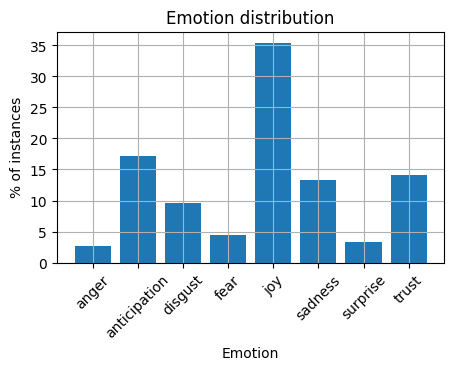

In [37]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)

plt.xticks(rotation=45, fontsize=10)

plt.show()

### 2. Feature Engineering